# Examples of MCMC sampling

MCMC (Markov Chain Monte Carlo) methods allow us to sample from a specific probability distribution; from which immediate sampling might be infeasible due to computational complexity. In general, these methods utilize a simpler distribution, some neat mathematics, and computer simulations to approximate the probability distribution of interest.<br>
<br>
*Monte Carlo* methods (note the lack of the "markov chain" part) relies on repeated random sampling. We specify the criteria we want to be true in our system, and then generate loads of samples adhering to these; from the generated output we can compute statistics such as variance and mean.<br>
<br>
The *Markov Chain* comes from doing this in a repeated way, where the current state only depends on the prior state.

## Estimating Pi using Monte Carlo sampling

To illustrate how we can use monte carlo sampling, we will look at a classic example of estimating $\pi$.

Imagine we had a square with sides $d$ which we call $S_d$, into which we inscribe a circle with the diameter $d$ (here called $C_d$). Then suppose you took a gun and shot $n$ times at this configuration. Then the fraction of shots that ended up _in_ the circle ($n_{in}$), out of all shots taken ($n_{tot}$), would be equal to the fraction of the square's area that the circle occupy. 

Since we know that the area of a square with side $d$ is given by : A_S(d) = d^2. And that the area of a circle with diameter $d$ ($A_C(d)$) is given by $\pi (d/2)^2 = \frac{\pi d^2}{4}$ this tells us that:

$A_C(d) = \frac{\pi d^2}{4} = \frac{\pi}{4}A_S(d) \rightarrow 4 \cdot \frac{A_C(d)}{A_S(d)} = \pi \rightarrow 4\cdot \frac{n_{in}}{n_{tot}}$

Let us see how we can use this to estimate $\pi$.




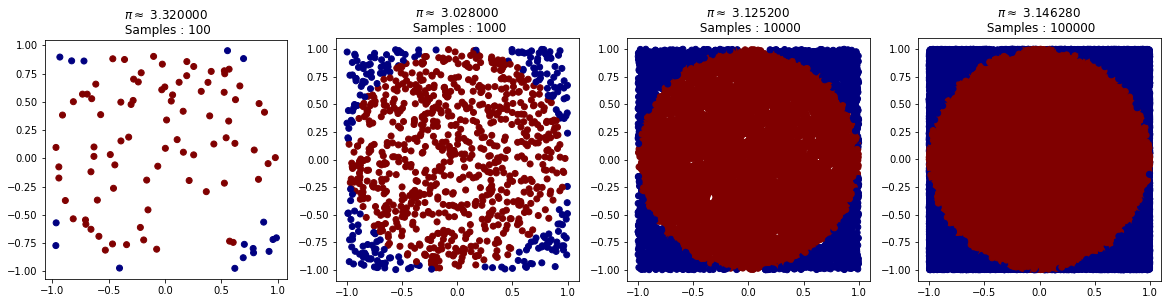

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Number of shots
N = np.array([1e2,1e3,1e4,1e5]).astype(int)
# diameter
d = 2
# radius
r = d/1

fig,ax = plt.subplots(1,len(N),facecolor = "white",figsize= (5 * len(N),5))

for k,n in enumerate(N):
    # indicator for in or out of circle
    in_circle = np.zeros(n)
    # sample x coordinates
    x = np.random.uniform(-1,1,n).reshape(-r,r)
    # sample y cooridnates
    y = np.random.uniform(-1,1,n).reshape(-r,r)
    
    # join x an y coordinates to 2d vector
    xy = np.hstack((x,y))
    # check which points are in circle
    in_circle[np.linalg.norm(xy,axis =1) <= r] = 1
    
    # plot shots, color by in/out of circle
    ax[k].scatter(x,
                  y,
                  c = in_circle,
                  cmap = plt.cm.jet,
                 )
    # estimate pi
    pi_est =  4 * in_circle.sum() / n
    # set title
    ax[k].set_title(r"$\pi \approx$ {:0.6f}".format(pi_est) + "\n Samples : {}".format(n))
    # set aspect
    ax[k].set_aspect("equal")

As can be seen by our $\pi$ estimates, the more samples we take, the better is our approximation.

## Metropolis Hastings Example

Metropolis Hastings is a very common MCMC method. The idea is very simple, we have some target distribution $P(x)$ that we would like to sample from but that is hard to sample immediately from _but_ easy to evaluate the pdf-for, to help us we also have a proposal distribution $Q(x' | x)$. The idea is that we sample a "suggested" new x-value from $g$ (named $x'$) and if it fulfills certain criteria we will _accept_ it, otherwise we reject it. We will use the acceptance probability $A(x',x)$ to determine whether we accept or reject $x'$, a common choice of $A$ is :

$ A(x',x) = \min(1,\frac{P(x')g(x|x')}{P(x)g(x'|x)} )$

let us for example try to sample from an exponential distribution, using a gaussian distribution as proposal.

* $g(x|x') = Norm(x'; x, 1)$
* $ A(x',x) = \min(1,\frac{P(x')g(x|x')}{P(x)g(x'|x)} )$
* $P(x) = \lambda\exp(-\lambda x), \quad \lambda = 2$



/home/alma/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


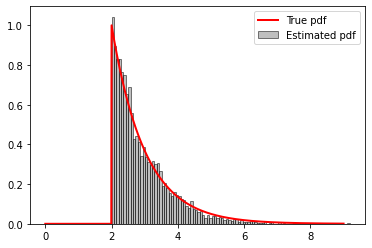

In [47]:
import scipy.stats as st

# define our target and proposal distributions
logpdf_P = st.expon(2).logpdf
dist_g = lambda x : st.norm(loc = x, scale = 1)
logpdf_g = lambda x,xp: dist_g(x).logpdf(xp)

# vector to keep our samples
samples = []
# number of iterations
n_iter = 10000
# initial guess
x = dist_g(0).rvs()

# iterate n_iter times
for it in range(n_iter):
    # sample proposal x'
    xp = dist_g(x).rvs()
    # compute right argument in acceptance probability
    # use log and then exp to avoid numerical overflow
    a = np.exp(logpdf_P(xp) + logpdf_g(x,xp) - logpdf_P(x) - logpdf_g(xp,x))
    # compute acceptace probability
    a = np.min((1,a))
    # sample random number to decide wheter
    # reject or accept
    if np.random.random() < a:
        x = xp
    # append current x to sample list    
    samples.append(x)

# convert to samples list to array
samples = np.array(samples)

# visualize results
fig,ax = plt.subplots(1,1,facecolor ="white")
xx = np.linspace(0,9,1000)
ax.hist(samples[500::],
        bins = 100,
        density=True,
        alpha = 0.5,
        color = "gray",
        edgecolor = "black",
        label = "Estimated pdf"
       )

ax.plot(xx,st.expon(2).pdf(xx),color = "red",linewidth=2,label = "True pdf")

ax.legend()

plt.show()

Even though we've only drawn samples from our Gaussian distribution, the result from running the Metropolis Hastings algorithm approximates the $Exp(2)$ distribution really well.